In [17]:
from mmseg.datasets.pipelines import Compose
from mmcv import Config
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch
import numpy as np
import tifffile 
from mmseg.models.utils.dacs_transforms import strong_transform, get_class_masks
import random

In [2]:
cfg = Config.fromfile('configs/mic/I3toLW4_mic_hrda_noise_2.py')

In [12]:
cfg.img_norm_cfg

{'mean': [123.675], 'std': [58.395], 'to_rgb': True}

In [4]:
# Load your config file
cfg = Config.fromfile('configs/_base_/datasets/uda_I3_to_LW4_3D.py')

# Build pipeline
pipeline = Compose(cfg.data.train.source.pipeline)

In [35]:
data_target = dict(
    img_info=dict(filename='images/patch_0057.tif'),
    ann_info=dict(seg_map='labels/patch_0057.tif'),
    img_prefix='data/LW4/patch_dataset',
    seg_prefix='data/LW4/patch_dataset',
    pseudo_label_prefix='data/LW4/patch_dataset',  # <--- Add this
    pseudo_label='sam/patch_0057.tif',                              # <--- And this
    seg_fields=[],
    sam_fields=[]
)

# Apply pipeline
processed_target = pipeline(data_target)

In [36]:
img_target = processed_target["img"].data
mask_target = processed_target["gt_semantic_seg"].data
sam_target = processed_target["sam_pseudo_label"].data

In [37]:
img_target.shape

torch.Size([1, 1, 40, 128, 128])

In [5]:
# Load a sample
data = dict(
    img_info=dict(filename='images/patch_0000.tif'),
    ann_info=dict(seg_map='labels/patch_0000.tif'),
    img_prefix='data/I3/patch_dataset',
    seg_prefix='data/I3/patch_dataset',
    pseudo_label_prefix='data/I3/patch_dataset',  # <--- Add this
    pseudo_label='sam/patch_0000.tif',                              # <--- And this
    seg_fields=[],
    sam_fields=[]
)

# Apply pipeline
processed = pipeline(data)

In [6]:
processed['gt_semantic_seg'].data.shape

torch.Size([1, 40, 128, 128])

In [30]:
means = torch.tensor(cfg.img_norm_cfg.mean)
stds = torch.tensor(cfg.img_norm_cfg.std)

In [31]:
img = processed['img'].data
img = (img * stds) + means # denormalize

mask = processed['gt_semantic_seg'].data

sam = processed["sam_pseudo_label"].data

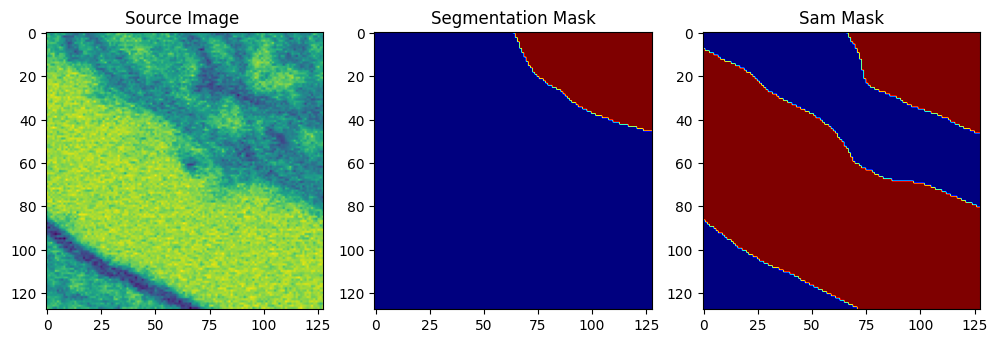

In [ ]:


img = processed['img'].data.squeeze().numpy() 
img = (img * cfg.img_norm_cfg['std']) + cfg.img_norm_cfg['mean']  # denormalize
img = img.astype(np.uint8)

mask = processed['gt_semantic_seg'].data.squeeze().numpy()

sam = processed["sam_pseudo_label"].data.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.title("Source Image ")


plt.subplot(1, 3, 2)
plt.imshow(mask[0], cmap='jet')  
plt.title("Segmentation Mask")


plt.subplot(1, 3, 3)
plt.imshow(sam[0], cmap='jet')  
plt.title("Sam Mask")
mix_masks

plt.tight_layout()
plt.show()

In [41]:
processed['img'].data.shape

torch.Size([1, 1, 40, 128, 128])

In [7]:
mask = processed['gt_semantic_seg'].data

In [8]:
mix_masks = get_class_masks(mask,True)

In [24]:
strong_parameters = {
            'mix': None,
            'color_jitter': random.uniform(0, 1),
            'color_jitter_s': 0.25,
            'color_jitter_p': 0.2,
            'blur': random.uniform(0, 1) ,
            'mean': means.unsqueeze(0),  # assume same normalization
            'std': stds.unsqueeze(0)
        }

In [33]:
mask.shape

torch.Size([1, 40, 128, 128])

In [38]:
strong_parameters['mix'] = mix_masks[0]
mixed_img, mixed_lbl = strong_transform(strong_parameters, data=torch.stack((img[0], img_target[0])),  #ici source_img et target_img
                                                target=torch.stack((mask[0], mask_target[0])))

In [44]:
mask.shape

torch.Size([1, 40, 128, 128])

In [96]:
a[0].shape

torch.Size([1, 1, 40, 128, 128])

In [ ]:
mixed_img, mixed_lbl 

In [44]:
tifffile.imwrite("./img_target.tif",img_target.squeeze().numpy().astype(np.uint8))

In [42]:
tifffile.imwrite("./mixed_lbl.tif",mixed_lbl.squeeze().numpy().astype(np.uint8))